# *Libraries Setup*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
param_grid = {
        'RF': 
        {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'criterion':['log_loss', 'entropy', 'gini'],
                'max_features':['sqrt', 'log2'],
                'bootstrap':[True,False],
                'class_weight':['balanced', 'balanced_subsample']
        },
        'SVC': {
                'C': [0.1, 1, 3, 5],
                'gamma':[0.005, 0.5, 0.05, 0,.01],
                'kernel': ['linear', 'rbf']
        },        
        'KNN': {
                'n_neighbors': [3, 5, 9, 12, 15, 17, 21],
                'weights': ['uniform', 'distance'],
                'algorithm': ['auto', 'ball_tree', 'kd_tree'],
                'leaf_size': [10, 20, 30, 40, 50]
        },
        'LR':{
            'C':[1,5,10],
            'solver':['lbfgs', 'newton-cg', 'sag', 'saga']
        },
        'DTree': {
            'min_samples_split':[1,3,5,10],
            'max_depth':[5,10,15,20],
            'max_leaf_nodes':[2,3,5,7,10],
            'criterion':['log_loss', 'entropy', 'gini'],
            'splitter':['best', 'random']
        },
        'MLP':{
            'learning_rate_init':[0.005,0.001,0.05,0.01],
            'alpha':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05],
            'solver':['lbfgs', 'sgd', 'adam']
        }


}

## *Data Loading*

In [3]:
def load_data():
    data = pd.read_csv("../data/raw/data.csv", sep=';')
    return data

# *Data Split*

In [4]:
def split_data(data, test):
    X = data.drop(['Target'], axis=1)
    y = data['Target']
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test, stratify=y)
    print("La dimension del conjunto de entrenamiento es: ",Xtrain.shape)
    print("La dimension del conjunto de prueba es: ",Xtest.shape)
    return Xtrain, Xtest, ytrain, ytest

# *Correlation Matrix*

In [5]:
def correlation_matrix(data):
    sns.set(rc={'figure.figsize':(30,30)})
    sns.heatmap(round(data.corr(numeric_only=True),2), annot=True,cmap="crest")
    plt.show()

# *Histogram*

In [6]:
def histogram(data, bins, ax, variable):
  ax.set_title(variable)
  ax.hist(data, bins=bins)

# *Visualize Histograms with transformations*

In [7]:
def visualize_histograms(data):
    numericos = ['Previous qualification (grade)','Admission grade','Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP']
    fig, axes = plt.subplots(len(numericos), 7, figsize=(30,30))
    for i in range(len(numericos)):
        histogram(data[numericos[i]],20,axes[i][0], numericos[i]+'_original')
        histogram(np.sqrt(data[numericos[i]]),20,axes[i][1], numericos[i]+'_sqrt')
        histogram(np.log1p(data[numericos[i]]),20,axes[i][2], numericos[i]+'_log')
        histogram(np.power(data[numericos[i]],2),20,axes[i][3], numericos[i]+'_cuadrado')
        d = data[numericos[i]]
        if min(d) < 1:
            d = data[numericos[i]] + (abs((min(data[numericos[i]]))) + 1)
        box = pd.DataFrame(power_transform(d.to_numpy().reshape(-1, 1),method='box-cox'),columns=[numericos[i]])
        histogram(box,20,axes[i][4], numericos[i]+'_box-cox')
        scaler = StandardScaler()
        standard = pd.DataFrame(scaler.fit_transform(data[numericos[i]].to_numpy().reshape(-1, 1)))
        histogram(standard,20,axes[i][5], numericos[i]+'_StandardScaler')
        scaler = MinMaxScaler()
        minmax = pd.DataFrame(scaler.fit_transform(data[numericos[i]].to_numpy().reshape(-1, 1)))
        histogram(minmax,20,axes[i][6], numericos[i]+'_min-max')

    plt.tight_layout()
    plt.show()

# *PCA Analysis*

In [8]:
def get_PCA_components(data, ct_numericas):
    processed = ct_numericas.fit_transform(data)
    pca = PCA()
    x_projected = pca.fit_transform(processed)
    va = np.cumsum(pca.explained_variance_ratio_)
    components = None
    for i in range(len(va)):
        if va[i] > 0.9:
            print(f'El número de componentes que explican el 90% de la varianza son: {i+1}')
            components = i+1
            break
    return components

# *Process Data and Features*

In [9]:
def create_transformers(data):
    log_pipe = Pipeline([('Log', FunctionTransformer(np.log1p, feature_names_out='one-to-one'))] )
    log_pipe_nombres = ['Previous qualification (grade)','Admission grade', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)']
    scaler_pipe = Pipeline([('scaler', StandardScaler())] )
    scaler_pipe_nombres = ['Age at enrollment', 'Unemployment rate', 'Inflation rate', 'GDP']
    catOHE_pipeline = Pipeline( [('OneHot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))] )
    catOHE_pipeline_nombres = list(set(data.columns.values) - set(log_pipe_nombres + scaler_pipe_nombres))
    ct_numericas = ColumnTransformer( transformers=[
    ('log_transformer', log_pipe, log_pipe_nombres),
    ('standard_Scaler', scaler_pipe, scaler_pipe_nombres)
    ] )
    ct_categoricas = ColumnTransformer( transformers=[
        ('cat', catOHE_pipeline, catOHE_pipeline_nombres)
    ] )

    return ct_numericas, ct_categoricas

In [10]:
def get_total_categories(data, ct_categoricas):
    all_cat = ct_categoricas.fit_transform(data)
    total_categories = ct_categoricas.named_transformers_['cat'].get_feature_names_out()
    return total_categories

In [11]:
def sync_columns(reference, data):
    data = data[reference.columns]
    return data

In [12]:
def complete_features(data, total_categories):
    columns = data.columns
    missig_categories = list(set(total_categories)-set(columns))

    for missing in missig_categories:
        data[missing]=0
    
    return data

In [13]:
def process_features(data, pca_components, ct_categoricas, ct_numericas, total_categories):
    data_nums_processed = ct_numericas.fit_transform(data)
    pca = PCA()
    x_projected = pca.fit_transform(data_nums_processed)
    x_projected = pd.DataFrame(x_projected)
    data_cat_processed= ct_categoricas.fit_transform(data)
    onehot_columns = ct_categoricas.named_transformers_['cat'].get_feature_names_out()
    data_cat_processed_df = pd.DataFrame(data_cat_processed, columns=onehot_columns)
    data_cat_processed_df = complete_features(data_cat_processed_df, total_categories)
    componentes = x_projected.iloc[:,0:pca_components]
    componentes.reset_index(drop=True, inplace=True)
    data_cat_processed_df.reset_index(drop=True, inplace=True)
    data_final = pd.concat([componentes,data_cat_processed_df], axis=1)
    data_final.columns = data_final.columns.astype(str)

    return data_final

# *Generar modelos*

In [14]:
def get_models():
    models, names = list(), list()
    models.append(LogisticRegression(max_iter=1000))
    names.append('LR')
    models.append(KNeighborsClassifier())
    names.append('KNN')
    models.append(DecisionTreeClassifier())
    names.append('DTree')
    models.append(RandomForestClassifier(n_jobs=-1))
    names.append('RF')
    models.append(MLPClassifier( hidden_layer_sizes=(20,20),max_iter=10000))
    names.append('MLP')
    models.append(SVC())
    names.append('SVC')
    
    return models, names

# *Grid Search*

In [15]:
def model_grid_search(model, params, X_train, y_train):
    grid_search = GridSearchCV(estimator = model, param_grid = params, n_jobs = -1, verbose = 2, cv=3)
    grid_search.fit(X_train, y_train.ravel())
    best_mod = grid_search.best_params_
    return  best_mod

In [16]:
def get_hyperparameters(data, y , models, names, params):
    parameters = []
    for i in range(len(models)):
        result = model_grid_search(models[i], params[names[i]], data, y)
        parameters.append(result)
    return parameters

# *Validate Models*

In [17]:
def set_hyperparameters(models, parameters):
    for i in range(len(models)):
        models[i].set_params(**parameters[i])
    return models

In [18]:
def validate_models(models, names, data, y, parameters):
    for i in range(len(models)):
        pipeline = Pipeline(steps=[('m',models[i])])
        cv = RepeatedStratifiedKFold(n_splits=5,
                                        n_repeats=15,
                                        random_state=5
                                        )
        metrics = ['accuracy','precision_macro','recall_macro','f1_macro']
        scores = cross_validate(pipeline,
                                data,
                                np.ravel(y),
                                scoring=metrics,
                                cv=cv,
                                return_train_score=True,
                                error_score = 0,
                                )

        print('>> %s' % names[i])
        for j,k in enumerate(list(scores.keys())):
            if j>1:
                print('\t %s %.3f (%.3f)' % (k, np.mean(scores[k]),np.std(scores[k])))

# *Train Models*

In [19]:
def train(models, data, y):
    for model in models:
        model.fit(Xtrain,ytrain)
    
    return models

# *Evaluate Model*

In [20]:
def evaluate(models, names, test, train, pca, ct_categoricas, ct_numericas, total_categories):
    Xtest = process_features(test, pca, ct_categoricas, ct_numericas, total_categories)
    Xtest = sync_columns(train, Xtest)
    for i in range(len(models)):
        y_pred= models[i].predict(Xtest)
        print(f"\n>>Reporte final Test de {names[i]}:")
        print(classification_report(ytest, y_pred))

        cm = confusion_matrix(ytest, y_pred )
        fig, ax = plt.subplots(figsize=(5,5))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=models[i].classes_)
        plt.grid(False)
        disp.plot(ax=ax)

# *Main process*

La dimension del conjunto de entrenamiento es:  (3539, 36)
La dimension del conjunto de prueba es:  (885, 36)


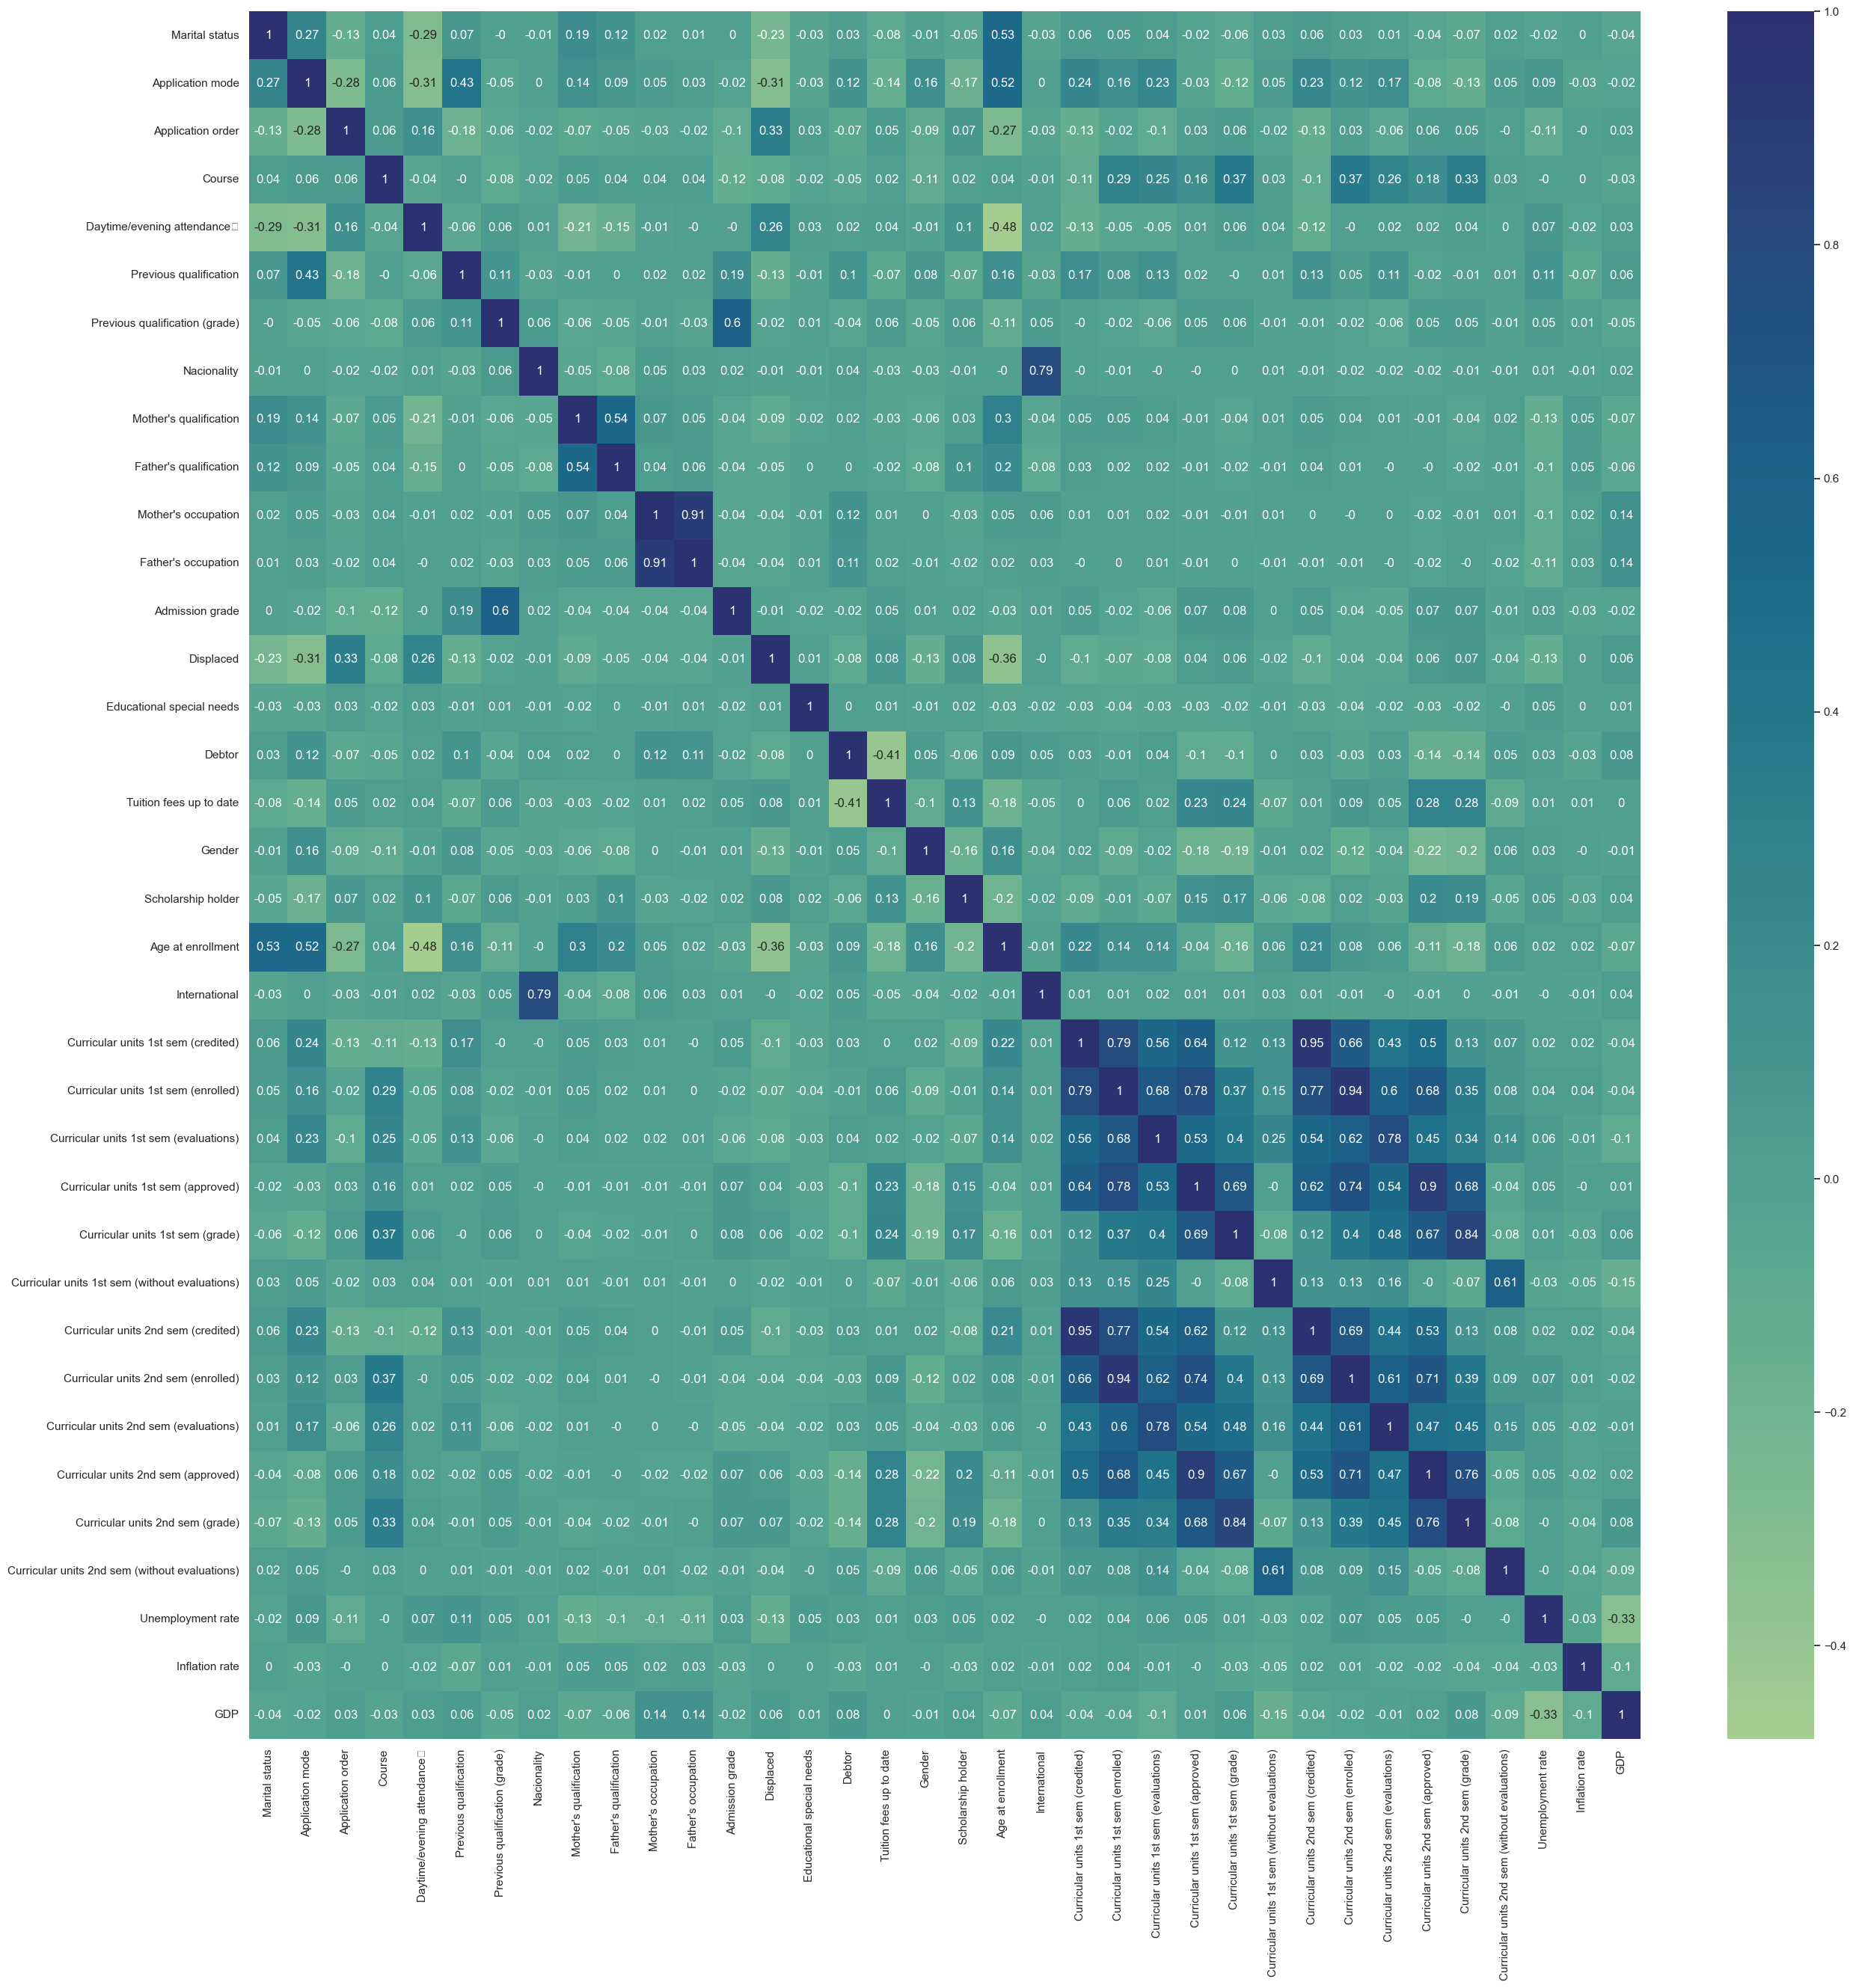

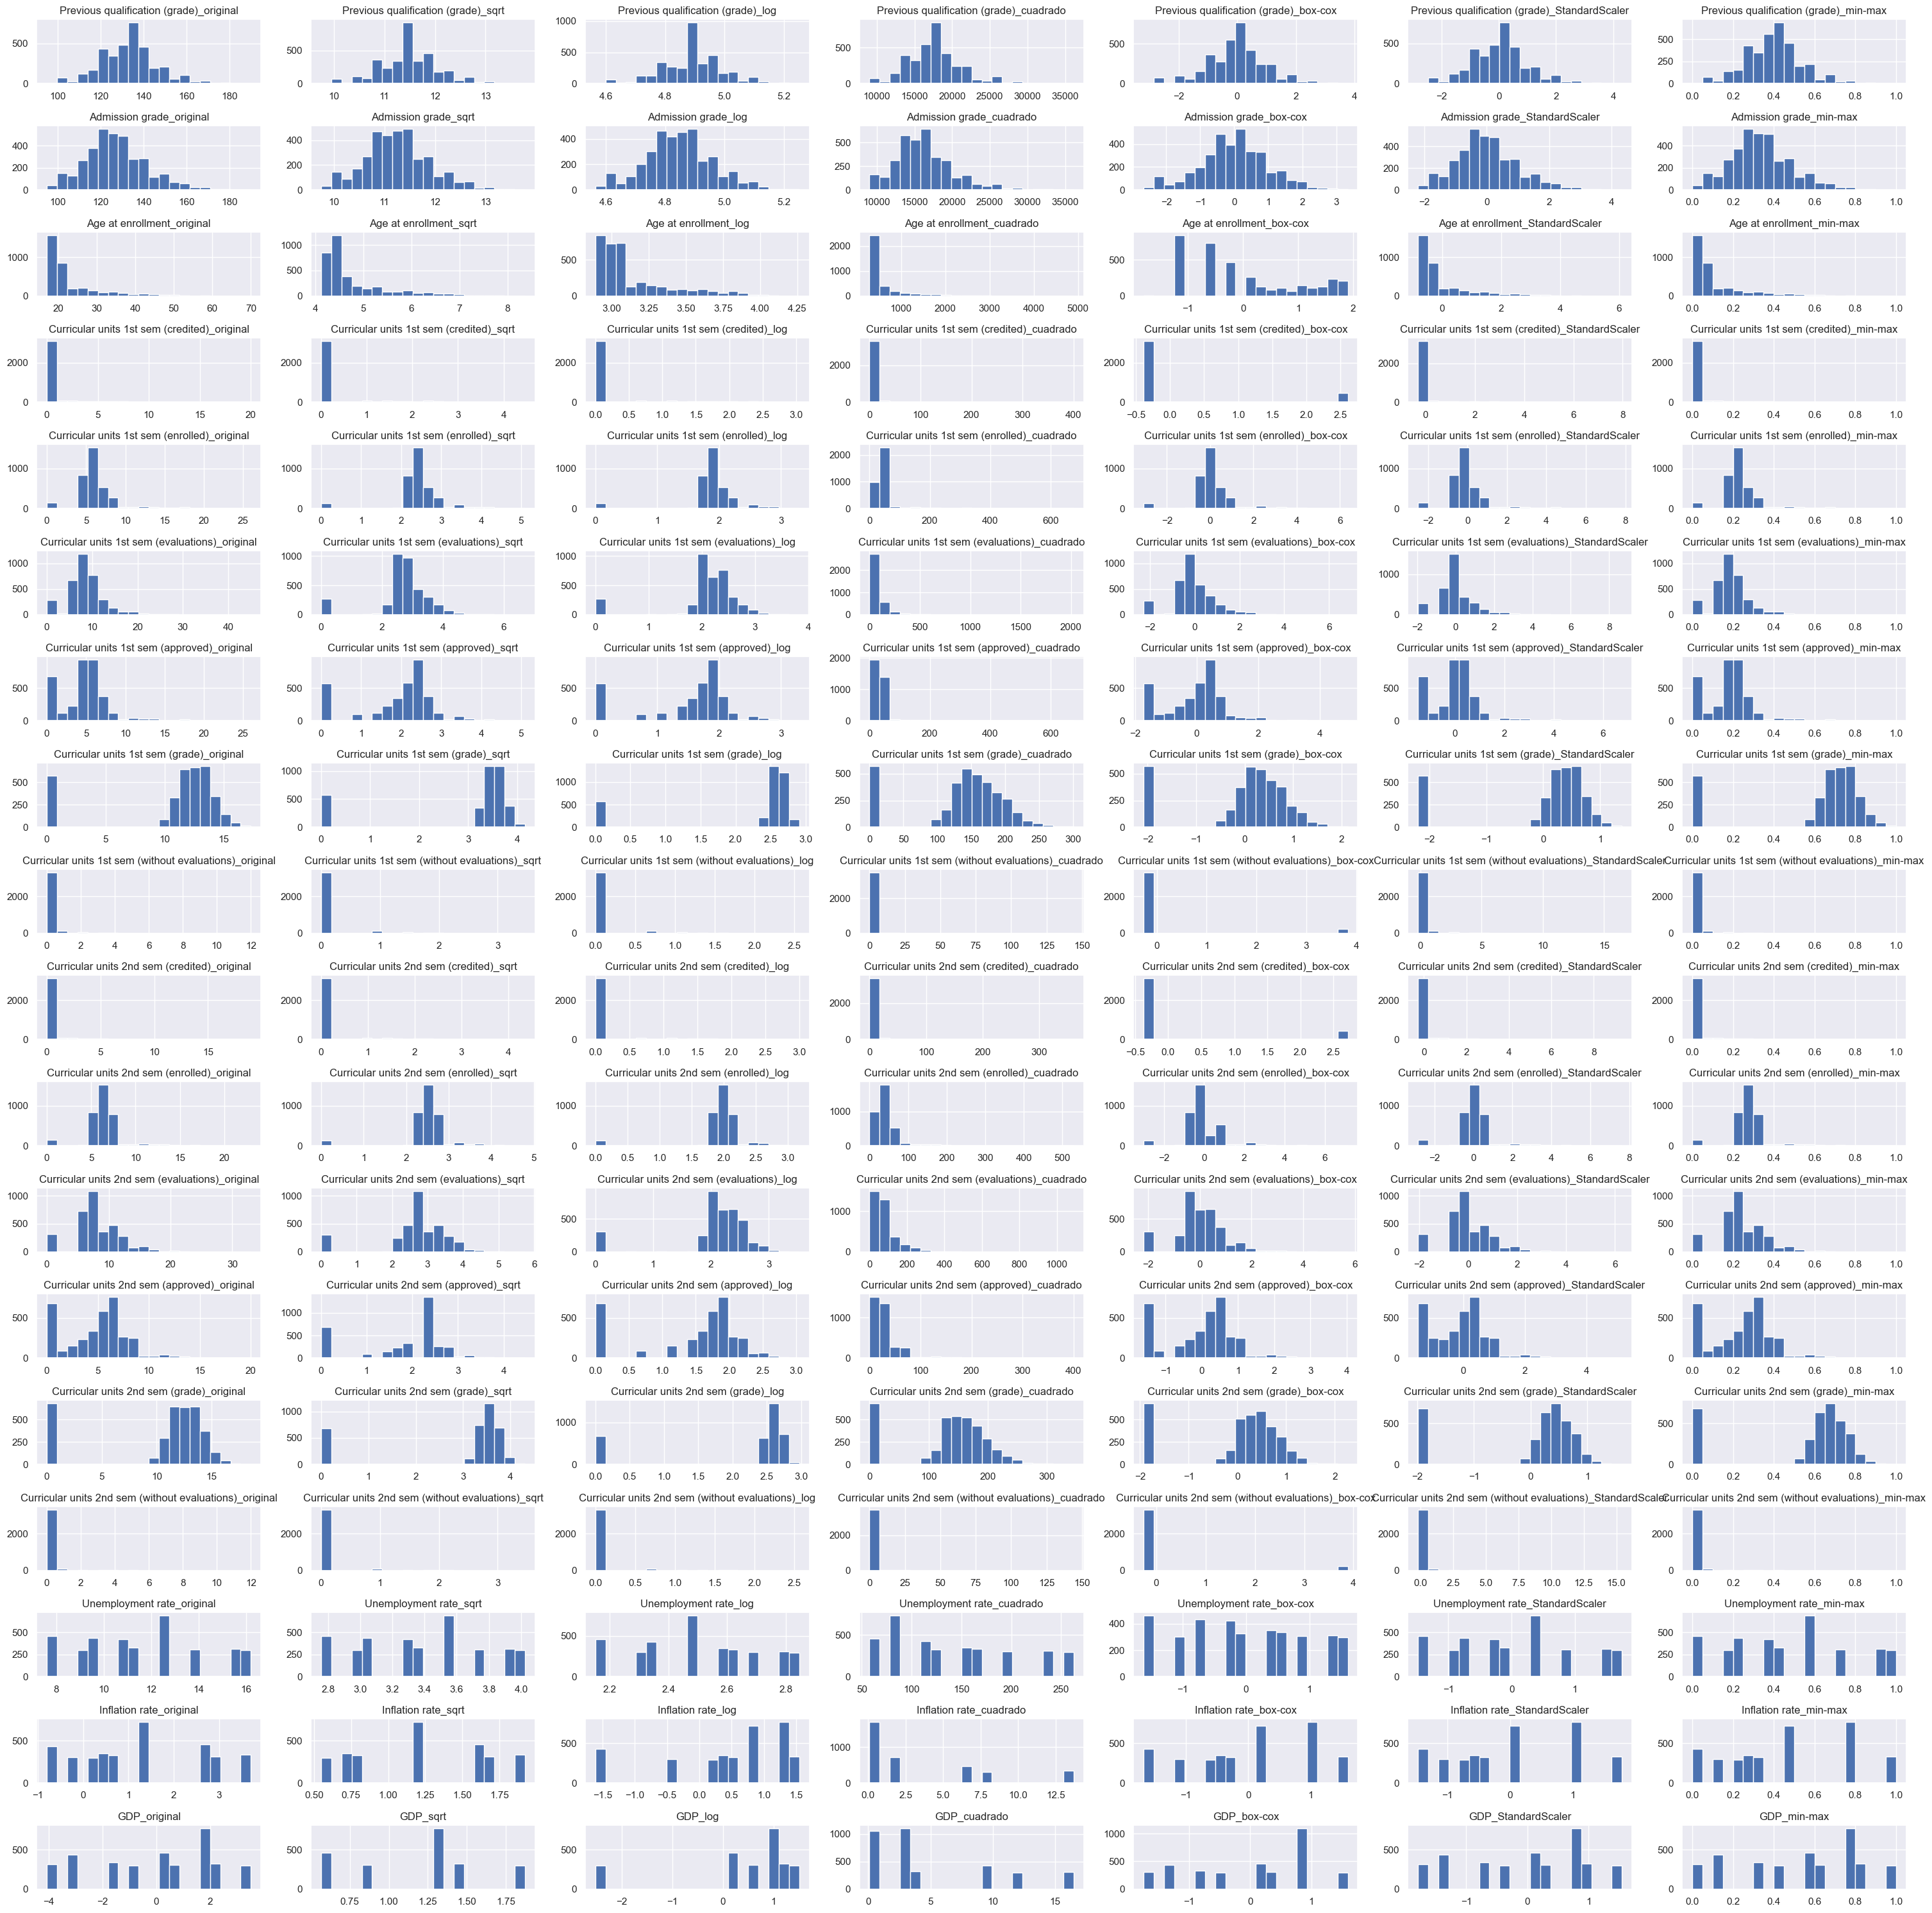

El número de componentes que explican el 90% de la varianza son: 7
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 210 candidates, totalling 630 fits
Fitting 3 folds for each of 480 candidates, totalling 1440 fits
Fitting 3 folds for each of 864 candidates, totalling 2592 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
>> LR
	 test_accuracy 0.761 (0.011)
	 train_accuracy 0.798 (0.003)
	 test_precision_macro 0.712 (0.017)
	 train_precision_macro 0.764 (0.005)
	 test_recall_macro 0.679 (0.014)
	 train_recall_macro 0.723 (0.005)
	 test_f1_macro 0.688 (0.015)
	 train_f1_macro 0.737 (0.005)
>> KNN
	 test_accuracy 0.680 (0.012)
	 train_accuracy 0.726 (0.005)
	 test_precision_macro 0.635 (0.024)
	 train_precision_macro 0.728 (0.011)
	 test_recall_macro 0.555 (0.013)
	 train_recall_macro 0.612 (0.007)
	 test_f1_macro 0.556 (0.016)
	 train_f1_macro 0.627 (0.009)
>> DTree
	 t

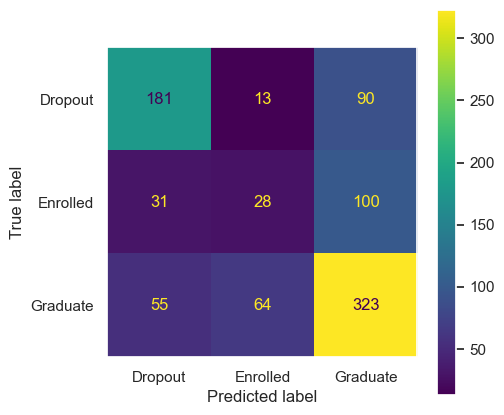

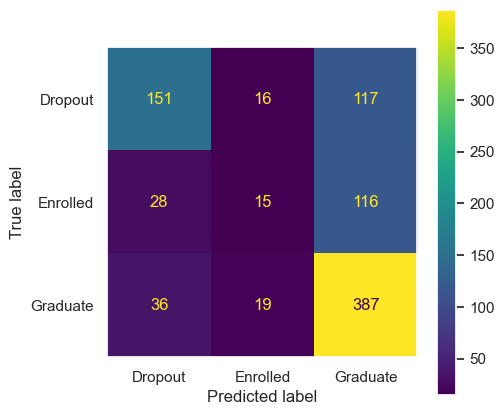

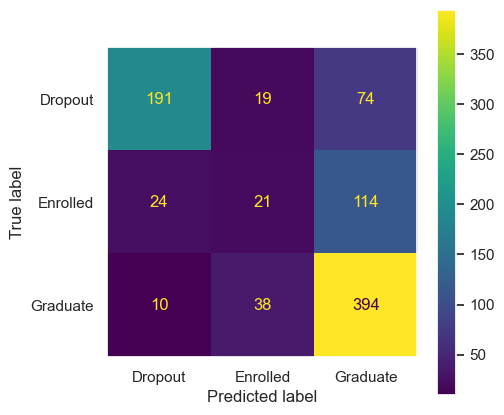

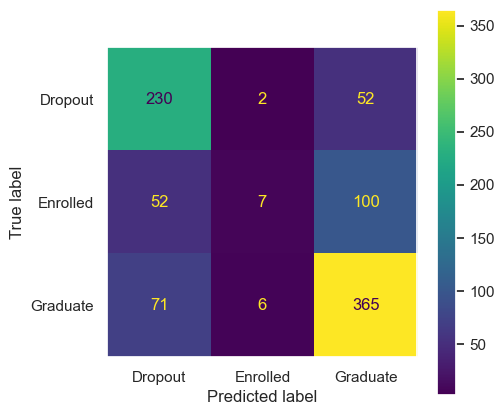

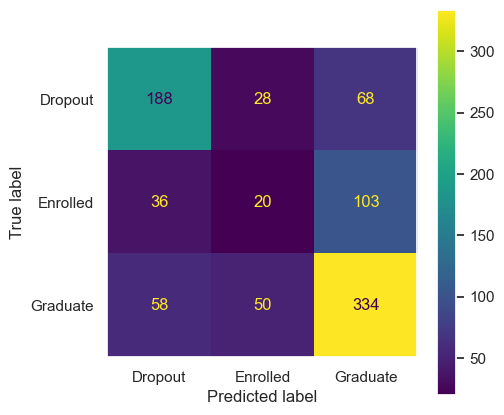

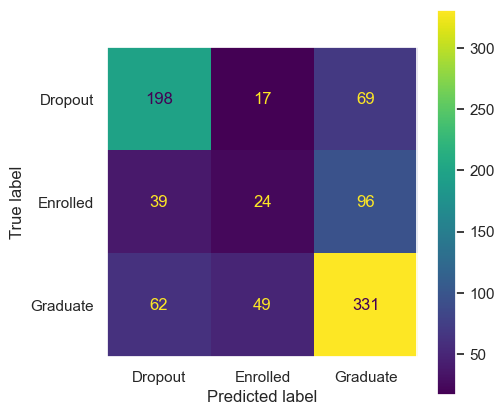

In [21]:
if __name__ == '__main__':
    data = load_data()
    Xtrain, Xtest, ytrain, ytest = split_data(data,0.2)
    correlation_matrix(Xtrain)
    visualize_histograms(Xtrain)
    ct_numericas, ct_categoricas = create_transformers(Xtrain)
    pca_components = get_PCA_components(Xtrain, ct_numericas)
    all_categories = get_total_categories(data, ct_categoricas)
    Xtrain = process_features(Xtrain, pca_components, ct_categoricas, ct_numericas, all_categories)
    models, names = get_models()
    parameters = get_hyperparameters(Xtrain, ytrain ,models , names, param_grid)
    models = set_hyperparameters(models,parameters)
    validate_models(models, names, Xtrain, ytrain, parameters)
    models = train(models, Xtrain, ytrain)
    evaluate(models, names, Xtest, Xtrain, pca_components, ct_categoricas, ct_numericas, all_categories)